Taken from : https://www.kaggle.com/leighplt/pytorch-starter-kit

In [29]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import torchvision
from torchvision import transforms, utils

import glob
import os

In [30]:
en_dict = {}
path = '../input/quickdraw-doodle-recognition/train_simplified'

filenames = glob.glob(os.path.join(path, '*.csv'))

filenames[:5]

['../input/quickdraw-doodle-recognition/train_simplified/traffic light.csv',
 '../input/quickdraw-doodle-recognition/train_simplified/rhinoceros.csv',
 '../input/quickdraw-doodle-recognition/train_simplified/bed.csv',
 '../input/quickdraw-doodle-recognition/train_simplified/school bus.csv',
 '../input/quickdraw-doodle-recognition/train_simplified/van.csv']

In [31]:
def encode_labels():
    counter = 0
    for fn in filenames:
        en_dict[fn[:-4].split('/')[-1].replace(' ', '_')] = counter
        counter += 1

In [32]:
encode_labels()

In [33]:
dec_dict = {v: k for k , v in en_dict.items()}

def decode_labels(label):
    return dec_dict[label]

In [34]:
decode_labels(181)

'The_Eiffel_Tower'

In [35]:
def get_label(nfile):
    #print(nfile[:-4].split('/')[-1].replace(' ', '_'))
    return en_dict[nfile[:-4].split('/')[-1].replace(' ', '_')]

In [36]:
get_label("../input/quickdraw-doodle-recognition/train_simplified/The Eiffel Tower.csv")

181

In [37]:
import pandas as pd
a = pd.read_csv('../input/quickdraw-doodle-recognition/train_simplified/The Eiffel Tower.csv').head().iloc[0]['drawing']
a.split(']]')

['[[[0, 22, 37, 64, 255], [218, 220, 227, 228, 211',
 ', [[76, 95, 135, 141, 150, 159, 166, 180, 186, 201], [220, 138, 31, 0, 63, 79, 117, 150, 191, 224',
 ', [[94, 104, 111, 119, 127, 141, 143, 142, 180, 191], [212, 167, 149, 80, 59, 41, 30, 134, 202, 232',
 ', [[109, 127, 137, 147, 150, 162, 172, 185], [122, 120, 104, 97, 99, 124, 128, 128',
 ', [[75, 130, 158], [162, 159, 150',
 ']']

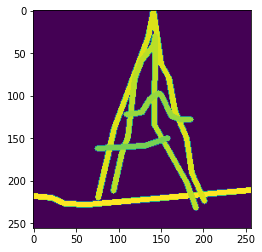

In [38]:
import ast
import numpy as np
import cv2
import matplotlib.pyplot as plt

new = ast.literal_eval(a)
new[0]

time_color = True

BASE_SIZE=256
lw = 6

img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
for t, stroke in enumerate(new):
#     print(stroke)
    for i in range(len(stroke[0]) - 1):
        color = 255 - min(t,10) * 13 if time_color else 255
        _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i+1], stroke[1][i+1]), color, lw)

plt.imshow(img)

In [39]:
class DoodleDataset(Dataset):
    def __init__(self, csv_file, root_dir, mode='train', nrows=1000, skiprows=None, size=256, transform=None):
        self.root_dir = root_dir
        file = os.path.join(root_dir, csv_file)
        self.size=size
        self.mode = mode
        self.doodle = pd.read_csv(file, usecols=['drawing'], nrows=nrows, skiprows=skiprows)
        self.transform = transform
        if self.mode == 'train':
            self.label = get_label(csv_file)
    
    @staticmethod
    def _draw(raw_strokes, size=256, lw=6, time_color=True):
        BASE_SIZE = 256
        img = np.zeros((BASE_SIZE, BASE_SIZE),np.uint8 )
        
        for t, stroke in enumerate(raw_strokes):
            for i in range(len(stroke[0]) - 1):
                color = 255 - min(t,10) * 13 if time_color else 255
                _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i+1], stroke[1][i+1]), color, lw)
        
        if size != BASE_SIZE:
            return cv2.resize(img, (size, size))
        
        else:
            return img
    
    def __len__(self):
        return len(self.doodle)
    
    def __getitem__(self, index):
        raw_strokes = ast.literal_eval(self.doodle.drawing[index])
        sample = self._draw(raw_strokes, size=self.size, lw=2, time_color=True)
        
        if self.transform:
            sample = self.transform(sample)
        
        if self.mode == 'train':
            return (sample[None]/255).astype('float32'), self.label
        else:
            return (sample[None]/255).astype('float32')
        

In [40]:
SIZE = 224
select_nrows= 10000

doodles = ConcatDataset([DoodleDataset(fn.split('/')[-1], path, mode='train', nrows=select_nrows, skiprows=None, size=SIZE, transform=None) for fn in filenames])


In [41]:
print(len(doodles))

train_dataloader = DataLoader(doodles, batch_size=128, shuffle=True, num_workers=0)

3400000


In [42]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

for images, label in train_dataloader:
    break
    

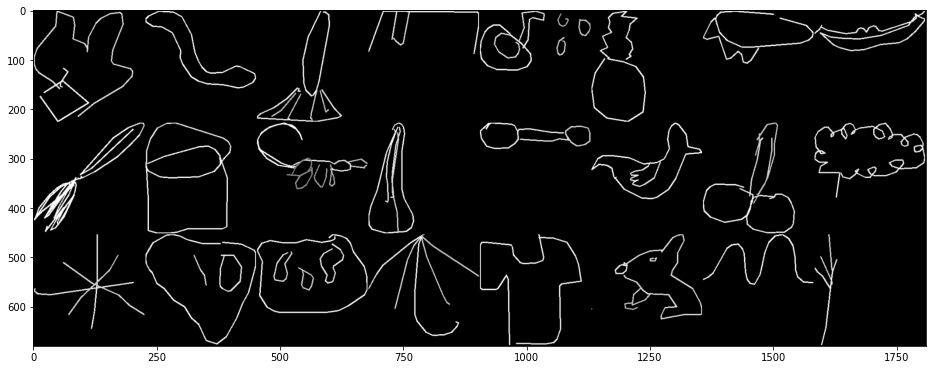

In [43]:
plt.figure(figsize=(16,24))
imshow(torchvision.utils.make_grid(images[:24]))

In [44]:
def validation(get_loader,lossfn, scorefn):
    model.eval()
    loss, score = 0,0
    vlen = len(get_loader)
    
    for X , y in get_loader:
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        
        loss += lossfn(output, y).item()
        score += scorefn(output, y)[0].item()
        
    model.train()
    return loss/vlen, score/vlen

In [45]:
def accuracy(output, target, topk=(3,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1,-1).expand_as(pred))
        
        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0,keepdim=True)
            res.append(correct_k.mul_(100.0/batch_size))
        return res

In [46]:
def mapk(output, target, k=3):
    """
    Computes the mean average precision at k.
    
    Parameters
    ----------
    output (torch.Tensor): A Tensor of predicted elements.
                           Shape: (N,C)  where C = number of classes, N = batch size
    target (torch.int): A Tensor of elements that are to be predicted. 
                        Shape: (N) where each value is  0≤targets[i]≤C−1
    k (int, optional): The maximum number of predicted elements
    
    Returns
    -------
    score (torch.float):  The mean average precision at k over the output
    """
    with torch.no_grad():
        batch_size = target.size(0)

        _, pred = output.topk(k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.reshape(1, -1).expand_as(pred))

        for i in range(k):
            correct[i] = correct[i]*(k-i)
            
        score = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        score.mul_(1.0 / (k * batch_size))
        return score

In [47]:
a = torch.randn(10,2,220,200)

k=5
a[:k].view(-1)

tensor([-1.2450,  0.0143, -1.6111,  ...,  0.9474, -1.0428, -1.4101])

In [48]:
model = torchvision.models.resnet18(pretrained=True)

In [49]:
def squeeze_weights(m):
    m.weight.data = m.weight.data.sum(dim=1)[:,None]
    m.in_channels = 1

model.conv1.apply(squeeze_weights)

num_classes = 340

model.fc = nn.Linear(512, out_features=num_classes, bias=True)

In [50]:
%%time
model(torch.randn(12,1,224,224)).size()

CPU times: user 615 ms, sys: 111 ms, total: 726 ms
Wall time: 725 ms


torch.Size([12, 340])

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad = True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5000, 12000, 18000], gamma=0.5)

In [53]:
%%time
epochs = 1
lsize = len(train_dataloader)
print(f"size of train : {lsize}")
itr =1
p_itr = 1000
model.train()
tloss, score =0,0
for epoch in range(epochs):
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        output = model(X)
        loss = criterion(output, y)
        tloss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        score += mapk(output, y)[0].item()
        scheduler.step()
        
        if itr %p_itr ==0 :
            print('Iteration {} -> Train Loss: {:.4f}, MAP@3: {:.3f}'.format(itr, tloss/p_itr, score/p_itr))
            tloss, score = 0, 0
        itr +=1
        if itr >= 6000:
            break 
            #you can continue this for better model
        

size of train : 26563
Iteration 1000 -> Train Loss: 2.4415, MAP@3: 0.213
Iteration 2000 -> Train Loss: 1.5905, MAP@3: 0.268
Iteration 3000 -> Train Loss: 1.4005, MAP@3: 0.279
Iteration 4000 -> Train Loss: 1.2769, MAP@3: 0.285
Iteration 5000 -> Train Loss: 1.2348, MAP@3: 0.287
CPU times: user 26min 13s, sys: 2.12 s, total: 26min 15s
Wall time: 26min 18s


In [54]:
filename_pth = 'checkpoint_resnet18.pth'
torch.save(model.state_dict(), filename_pth)

In [55]:
testset = DoodleDataset('test_simplified.csv', '../input/quickdraw-doodle-recognition/', mode='test', nrows=None, size=SIZE)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)

In [61]:
import tqdm

model.eval()
model = model.to(device)
labels = np.empty((0,3))
#labels = labels.to(device)
for x in tqdm.tqdm(testloader):
    x = x.to(device)
    output = model(x)
    _, pred = output.topk(3, 1, True, True)
    labels = np.concatenate([labels, pred.cpu()], axis = 0)

100%|██████████| 877/877 [02:03<00:00,  7.09it/s]


In [68]:
%%time
submission = pd.read_csv('../input/quickdraw-doodle-recognition/test_simplified.csv', index_col='key_id')
submission.drop(['countrycode', 'drawing'], axis=1, inplace=True)
submission['word'] = ''
for i, label in enumerate(labels):
    submission.word.iloc[i] = " ".join([decode_labels(l) for l in label])

CPU times: user 1min 2s, sys: 100 ms, total: 1min 3s
Wall time: 1min 3s


In [69]:
submission.to_csv('preds_resnet18.csv')

In [70]:
print("done")

done
